In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import HTML
HTML('<style>.container { width:97% !important; }</style><style>.output_png {display: table-cell;text-align: center;vertical-align: middle;}</style>')

# MODEL 1
## Kernel: Vectorixer 10bit
## PCA (from 1024 to 128)
## DNN-UMAP (100 epochs) (from 128 to 2)

In [3]:
from eden import graph
import load_data as ld
from sklearn.model_selection import train_test_split

from sklearn.decomposition import TruncatedSVD
import embedder
import utilities as ut

import embedder_generator as gen

In [4]:
#name = "generate_graphs/125_pos_neg_BALANCED(2038)" #Leukemia
#name = "generate_graphs/489028_pos_neg_BALANCED(2864)" #Cancer
#name = "generate_graphs/1111_pos_neg_BALANCED" # AIDS
#name = "generate_graphs/2222_pos_neg_(BALANCED)" # PROTEINS
name = "generate_graphs/3333_pos_neg_(BALANCED)" # DHFR
prot = False
# load data 
graphs,labels = ld.load_data_pubchem(name)
if (prot == True):
    print("removing_big_graphs")
    remove_big_graphs(graphs,labels)
                      

In [5]:
# vectorizer transform
X_in = graph.vectorize(graphs,nbits=10,complexity=2)

In [7]:
#split train test
X_train, X_test, labels_train, labels_test = train_test_split(X_in, labels, test_size=0.2, random_state=42)
ut.evaluate_emb_train_test(X_test.A,labels_test,X_train.A,labels_train)

DIM: 1025           TEST    TRAIN
----------------  ------  -------
K.N.N.  accuracy   0.927    0.953


# From n_bits to 128

In [8]:
# define the model
emb_pca = embedder.Transformer(TruncatedSVD(n_components=128))
# fit
emb_pca.fit(X_train,labels_train)
# transform
X128_train = emb_pca.transform(X_train)
X128_test = emb_pca.transform(X_test)
# evaluate
ut.evaluate_emb_train_test(X128_test,labels_test,X128_train,labels_train)

DIM: 128            TEST    TRAIN
----------------  ------  -------
K.N.N.  accuracy    0.92    0.951


# from 128 to 2

In [10]:
# define the model
uma_dnn = gen.gen_umap_dnn(auto_n_components = 128, emb_n_components = 2, dnn_epochs = 100,dnn_batch_size = 32)
# fit
uma_dnn.fit(X128_train,labels_train)
# transform
X2_train = uma_dnn.transform(X128_train)
X2_test = uma_dnn.transform(X128_test)

DIM: 2              TEST    TRAIN
----------------  ------  -------
K.N.N.  accuracy   0.984    0.994


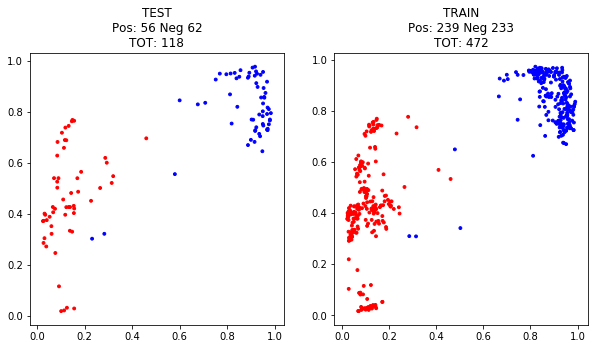

In [12]:
# evaluate
ut.evaluate_emb_train_test(X2_test,labels_test,X2_train,labels_train)
# plot
plot2d_tmp(X2_test,labels_test,X2_train,labels_train)

# Repeate the process 5 times
### Return (acc train/test dims: 128,32,2 - 5 embeddings 2d - 5 labels)

In [21]:
#name = "generate_graphs/125_pos_neg_BALANCED(2038)" #Leukemia
name = "generate_graphs/489028_pos_neg_BALANCED(2864)" #Cancer
#name = "generate_graphs/1111_pos_neg_BALANCED" # AIDS
#name = "generate_graphs/2222_pos_neg_(BALANCED)" # PROTEINS
#name = "generate_graphs/3333_pos_neg_(BALANCED)" # DHFR

n_bits = 10 #10
n_times = 5 #5

res = execute(name,n_bits,n_times,prot=False)

dim: 1024
TEST acc: 0.559
TRAIN acc: 0.681
DIM: 128            TEST    TRAIN
----------------  ------  -------
K.N.N.  accuracy   0.586    0.662
DIM: 2              TEST    TRAIN
----------------  ------  -------
K.N.N.  accuracy    0.51    0.874
dim: 1024
TEST acc: 0.638
TRAIN acc: 0.658
DIM: 128            TEST    TRAIN
----------------  ------  -------
K.N.N.  accuracy   0.617    0.644
DIM: 2              TEST    TRAIN
----------------  ------  -------
K.N.N.  accuracy   0.575     0.85
dim: 1024
TEST acc: 0.577
TRAIN acc: 0.665
DIM: 128            TEST    TRAIN
----------------  ------  -------
K.N.N.  accuracy   0.543    0.652
DIM: 2              TEST    TRAIN
----------------  ------  -------
K.N.N.  accuracy   0.502    0.865
dim: 1024
TEST acc: 0.594
TRAIN acc: 0.660
DIM: 128            TEST    TRAIN
----------------  ------  -------
K.N.N.  accuracy   0.598    0.645
DIM: 2              TEST    TRAIN
----------------  ------  -------
K.N.N.  accuracy   0.517    0.864
dim: 1024
TE

# Save the results

In [22]:
#res_mutag
np.save("Model1_vec_res_canc",res, allow_pickle=True)

# Used methods

In [12]:
from sklearn.model_selection import StratifiedKFold
import numpy as np
def execute(name,n_bits=10,n_times=5,prot=False):
    acc_1024_test = []
    acc_1024_train = []
    acc_128_test = []
    acc_128_train = []
    acc_2_test = []
    acc_2_train = []
    X2_test = []
    X2_train = []
    lab_test = []
    lab_train = []
    
    
    kFold = StratifiedKFold(n_splits=5)
    
    graphs,labels = ld.load_data_pubchem(name)
       
    
    # vectorizer transform
    X_in = graph.vectorize(graphs,nbits=10,complexity=2)
    X_in = X_in.A
    
    #split train test
    count = 0
    for train, test in kFold.split(X_in, labels):
        if (count == n_times):
            break
            
        X_in_train = X_in[train]
        X_in_test = X_in[test]
        labels_train = labels[train]
        labels_test = labels[test]
        ### evaluate Vectorize in dim 1024
        acc_1024_te, acc_1024_tr = ut.evaluate_emb_train_test(X_in_test,labels_test,X_in_train,labels_train,return_value=True)
        print("dim: 1024")
        print("TEST acc: "+ str(acc_1024_te))
        print("TRAIN acc: "+ str(acc_1024_tr))
        
        acc_128_te,acc_128_tr,acc_2_te,acc_2_tr,X2_te,X2_tr = run(X_in_train, X_in_test, labels_train, labels_test)
        
        acc_1024_test.append(float(acc_1024_te))
        acc_1024_train.append(float(acc_1024_tr))
        acc_128_test.append(acc_128_te)
        acc_128_train.append(acc_128_tr)
        acc_2_test.append(acc_2_te)
        acc_2_train.append(acc_2_tr)
        X2_test.append(X2_te)
        X2_train.append(X2_tr)
        lab_test.append(labels_test)
        lab_train.append(labels_train)
        
        count = count + 1
        
    return([acc_1024_test,acc_1024_train,acc_128_test,acc_128_train,acc_2_test,acc_2_train,X2_test,X2_train,lab_test,lab_train])

In [13]:
def run(X_in_train, X_in_test, labels_train, labels_test):

    
    emb_pca = embedder.Transformer(TruncatedSVD(n_components=128))
    emb_pca.fit(X_in_train,labels_train)
    X128_train = emb_pca.transform(X_in_train)
    X128_test = emb_pca.transform(X_in_test)
    ut.evaluate_emb_train_test(X128_test,labels_test,X128_train,labels_train)
    acc_128_test, acc_128_train = ut.evaluate_emb_train_test(X128_test,labels_test,X128_train,labels_train,return_value=True)


    # 128 to 2
    uma_dnn = gen.gen_umap_dnn(auto_n_components = 128, emb_n_components = 2, dnn_epochs = 100,dnn_batch_size = 32)
    uma_dnn.fit(X128_train,labels_train)

    X2_train = uma_dnn.transform(X128_train)
    X2_test = uma_dnn.transform(X128_test)
    ut.evaluate_emb_train_test(X2_test,labels_test,X2_train,labels_train)       
    acc_2_test, acc_2_train = ut.evaluate_emb_train_test(X2_test,labels_test,X2_train,labels_train,return_value=True)
    
    
    acc_128_test = float(acc_128_test)
    acc_128_train = float(acc_128_train)
    acc_2_test = float(acc_2_test)
    acc_2_train = float(acc_2_train)
    
    return(acc_128_test,acc_128_train,acc_2_test,acc_2_train,list(X2_test),list(X2_train))
    

In [11]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
def plot2d_tmp(res_test,y_test,res_train,y_train):
    _,[pos_tra,neg_tra] = np.unique(y_train,return_counts=True)
    _,[pos_tes,neg_tes] = np.unique(y_test,return_counts=True)

    colors = ['red','blue']
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    x = res_test[:,0]
    y = res_test[:,1]
    plt.title("TEST\nPos: "+str(pos_tes)+" Neg "+str(neg_tes)+"\nTOT: "+str(len(y_test)))
    plt.scatter(x,y,s=8,c=y_test,cmap=matplotlib.colors.ListedColormap(colors))


    plt.subplot(122)
    x = res_train[:,0]
    y = res_train[:,1]
    plt.title("TRAIN\nPos: "+str(pos_tra)+" Neg "+str(neg_tra)+"\nTOT: "+str(len(y_train)))
    plt.scatter(x,y,s=8,c=y_train,cmap=matplotlib.colors.ListedColormap(colors))

    plt.show()
    
import networkx as nx
def remove_big_graphs(graphs_in,labels_in):
    grpahs_in = np.array(graphs_in)
    print("sto eliminado i grafi grandi")
    graphs = []
    labels = []
    for j in range(len(graphs_in)):
        n_nodes = graphs_in[j].number_of_nodes() 
        if (n_nodes < 150):
            graphs.append(graphs_in[j])
            labels.append(labels_in[j])
    print(len(graphs))
    graphs = np.array(graphs)
    labels = np.array(labels)
    return(graphs,labels)
    